In [1]:
#PARAMETERS TO SET BY USER
num_clusters_max = 12 # max number of clusters that you believe should exist  #if more than this need to add colors for plotting
num_clusters_min = 1 # minium number of clusters you believe should exist
num_clusters_step = 1
num_words = 10 # number of words to print out per cluster

In [45]:
# from __future__ import print_function

# import nltk
# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.corpus import stopwords, wordnet
# from nltk.stem.wordnet import WordNetLemmatizer

# import gensim
# from math import floor
# from scipy.interpolate import UnivariateSpline

# import numpy as np
# import pandas as pd
# import os, string
# import chardet
# from collections import Counter

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.cluster import KMeans
# from sklearn.externals import joblib
# from sklearn.manifold import MDS

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import mpld3  



In [3]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 560);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [4]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.15, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


In [5]:
def tfidf_feats(row, features):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    ids = np.argsort(row)[::-1][:]
    feats = [(features[i], row[i]) for i in ids]
    df = pd.DataFrame(feats)
    df.columns = ['feature', 'tfidf']
    return df

def cluster_feats(Xtr, features, grp_ids=None, min_tfidf=0.05):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return tfidf_feats(tfidf_means, features)

In [6]:
'''
Calculate cluster coherence
'''

def evaluate_clusters(dictionary, topics, texts):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    cvalue = -1000
    
    cm = gensim.models.CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='u_mass')

    return cm.get_coherence()

In [7]:
def get_cluster_dict(doc_cluster_pair):
    '''
    doc_cluster_pair = a dataframe with two columns indicating which cluster a document belongs to based on tf-idf
    
    key will be the index of the dataframe providing the cluster number
    '''
    
    cluster_dict = {}
    for key in doc_cluster_pair.indices.keys():
        for title, cluster in doc_cluster_pair.get_group(key).values:
            if cluster in cluster_dict.keys():
                cluster_dict.setdefault(cluster,[]).append(title.split("/")[-1])
            else:
                cluster_dict[cluster] = [title.split("/")[-1]]
                
    return cluster_dict

In [8]:
def filefinder(path, file_extension='.txt'):
    '''
    path = path to location of files you want to grab e.g.-> "C:/Joe/MyDocs/"
    file_extension = file type e.g.-> .txt, .pdf
    '''
    
    lst = []
    
    if not file_extension.startswith("."):
        file_extension = "."+file_extension
    
    with os.scandir(path) as f:
        for entry in f:
            if entry.name.endswith(file_extension) and entry.is_file():
                lst.append(path+"/"+entry.name)
    
    return lst

In [9]:
def cleaning(path, file_extension=".txt"):
    
    encoding = []
    corpus = []
    words = []
    files = filefinder(path, file_extension)
    
    for file in files:
        with open(file, "rb") as fh:
            text = fh.read()
            encoding.append(chardet.detect(text)['encoding'])
            
    for i in range(len(files)):
        with open(files[i], encoding=encoding[i]) as fh:
            text = fh.read()
            corpus.append(text)
            
    stop = set(stopwords.words('english'))
    stop |= set(['like',"it's", 'get', "don't", 'even', "you've", 
                 "you're", "what's", "didn't", "wasn't",
                "doesn't"])
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    
    for doc in corpus:
        stop_free = " ".join([i for i in doc.lower().split() if i.strip() not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        short_free = " ".join(w for w in punc_free.split() if len(w) > 4)
        number_free = " ".join(w for w in short_free.split() if not any(c.isdigit() for c in w))
        normalized = " ".join(lemma.lemmatize(word) for word in number_free.split())
        word_check = " ".join(w for w in normalized.split() if wordnet.synsets(w))
        word_check = word_check.split()
        words.append(word_check)
  
    return words

In [11]:
titles = filefinder(filePath)
titles = [title.replace('\\','/') for title in titles]

In [12]:
#shorten titles to remove full path
titles_short = []
for title in titles:
    titles_short.append(title.split('/')[-1])

In [13]:
words = cleaning(filePath)

In [14]:
tokens_by_doc = words.copy()

In [15]:
#print(titles[:10]) #first 10 titles

In [16]:
print(words[0][:20]) #first 200 elements in words (for 'reference_1.txt')

['hank', 'greeted', 'wintry', 'premiere', 'hollywood', 'hank', 'london', 'leicester', 'square', 'premiere', 'polar', 'express', 'landmark', 'turned', 'festive', 'landscape', 'complete', 'carol', 'singer', 'celebrate']


In [17]:
totalvocab_index = [] #to be used as a dictionary index
totalvocab_bow = [] #bag of tokenized words

for ls in words:
    totalvocab_index.extend(ls)
    totalvocab_bow.extend(ls)

In [18]:
vocab_frame = pd.DataFrame({'words': totalvocab_bow}, index = totalvocab_index)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 56686 items in vocab_frame


In [19]:
vocab_frame.drop_duplicates(['words'], inplace=True)

In [20]:
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 8242 items in vocab_frame


In [21]:
words = [" ".join(w for w in ls) for ls in words]
print(words[0][:200]) #first 200 characters in reference_1.txt after cleaning 

hank greeted wintry premiere hollywood hank london leicester square premiere polar express landmark turned festive landscape complete carol singer celebrate arrival animated leicester square never bef


In [22]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2)
tfidf_vectorizer = TfidfVectorizer(max_df=0.2, min_df=0.05)
tfidf_matrix = tfidf_vectorizer.fit_transform(words) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

(438, 383)


In [23]:
# terms is just a list of the features used in the tf-idf matrix. This is a vocabulary
terms = tfidf_vectorizer.get_feature_names()

In [24]:
'''
dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more synopses.
'''
dist = 1 - cosine_similarity(tfidf_matrix)

In [25]:
'''
K-means clustering
Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.
'''

if num_clusters_max+1 > len(titles):
    num_clusters_max = len(titles)
    
if num_clusters_min < 1:
    num_clusters_min = 1
    
if num_clusters_max <= num_clusters_min:
    num_clusters_max = num_clusters_min+1
    
clus_ls = []
tops_ls = list(range(num_clusters_min,num_clusters_max+1,num_clusters_step))
    
for csize in range(num_clusters_min,num_clusters_max+1,num_clusters_step):
    km = KMeans(n_clusters=csize)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    docs = { 'title': titles, 'cluster': clusters }

    df = pd.DataFrame(docs, index = [clusters] , columns = ['title', 'cluster'])

    grouped = df.groupby(df['cluster'])

    cluster_dict = get_cluster_dict(grouped)

    cluster_words = []

    for key, values in cluster_dict.items():
        ids = []
        for title in values:
            ids.append(titles_short.index(title))
        df_terms_by_cluster = cluster_feats(tfidf_matrix, terms, grp_ids=ids)
        cluster_words.append(df_terms_by_cluster[df_terms_by_cluster['tfidf'] > 0.0]['feature'].tolist())
    
    dictionary = gensim.corpora.Dictionary(cluster_words)
    corpus = [dictionary.doc2bow(token) for token in cluster_words]

    clus = evaluate_clusters(topics=cluster_words, texts=tokens_by_doc, dictionary=dictionary)
    clus_ls.append(clus)


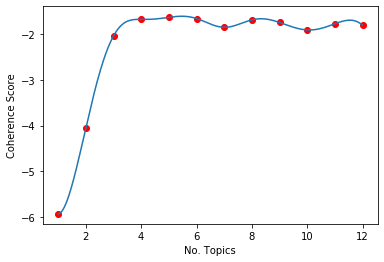

In [26]:
'''
fit line to the data points calcuated by coherence model above
'''
x = tops_ls
y = clus_ls

y_spl = UnivariateSpline(x,y,s=0,k=4)
x_range = np.linspace(x[0],x[-1],1000)

fig = plt.figure()
plt.plot(x,y,'ro',label='data') #plot data points (red dots)
plt.plot(x_range,y_spl(x_range)) #plot fit to the data (blue line)
plt.xlabel('No. Topics')
plt.ylabel('Coherence Score')
plt.show()
fig.savefig("coherence_model_curve.png", bbox_inches='tight', dpi=600)
plt.close()

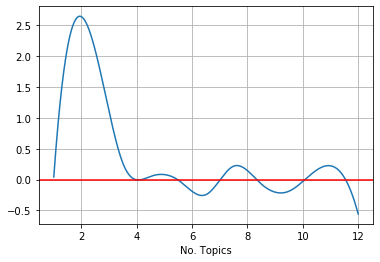

In [27]:
'''
signs and slopes of tangent lines from first derivative
'''
y_spl_1d = y_spl.derivative(n=1)

fig = plt.figure()
plt.plot(x_range,y_spl_1d(x_range))
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel('No. Topics')
plt.grid(True)
plt.show()
fig.savefig("coherence_model_slope.png", bbox_inches='tight', dpi=600)
plt.close()

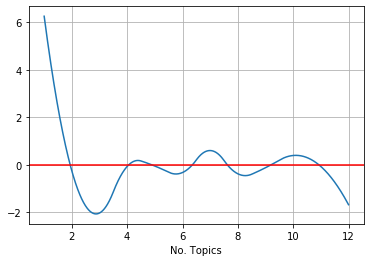

In [28]:
'''
Find inflection points using second deriviative
'''
y_spl_2d = y_spl.derivative(n=2)

fig = plt.figure()
plt.plot(x_range,y_spl_2d(x_range))
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel('No. Topics')
plt.grid(True)
plt.show()
fig.savefig("coherence_model_inflec_pts.png", bbox_inches='tight', dpi=600)
plt.close()

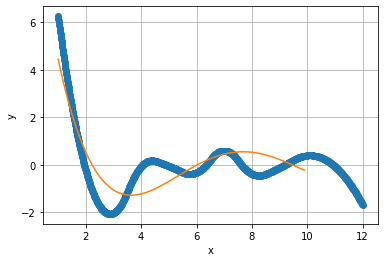

Possible numbers of clusters to try are: [9, 2, 6]


In [29]:
'''
TEST CODE
'''

coefficients = np.polyfit(x_range,y_spl_2d(x_range), 4)
polynomial = np.poly1d(coefficients)
xs = np.arange(1.0, 10, 0.1)
ys = polynomial(xs)

plt.grid(True)
plt.plot(x_range,y_spl_2d(x_range), 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()
plt.close()

num_clusters_ls = []
zero_crossings = np.where(np.diff(np.sign(ys)))[0] #index values where line crosses zero
for cross in range(len(zero_crossings)):
    num_clusters_ls.append(floor(xs.item(zero_crossings[cross])))
num_clusters_ls = list(set(num_clusters_ls))
print("Possible numbers of clusters to try are: {}".format(num_clusters_ls))

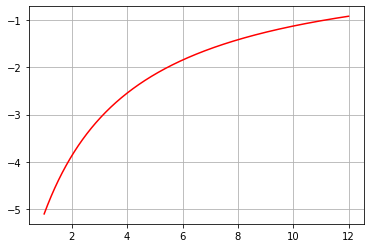

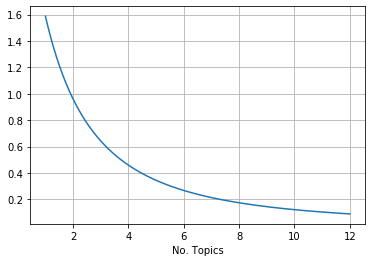

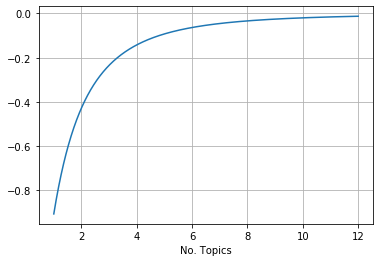

In [30]:
'''
TEST CODE
'''
from scipy import optimize
def func(x, a, b):
    return 1/(1+(1/b-1)*np.exp(-a*x))

popt, pcov = optimize.curve_fit(func, x_range,y_spl(x_range))
y_range = func(x_range,*popt)

plt.grid(True)
# plt.plot(x_range,y_spl(x_range), 'ko', label="Original Noised Data")
plt.plot(x_range, y_range, 'r-', label="Fitted Curve")
plt.show()
plt.close()

y_spl = UnivariateSpline(x_range,y_range,s=0,k=4)
y_spl_1d = y_spl.derivative(n=1)

fig = plt.figure()
plt.plot(x_range,y_spl_1d(x_range))
plt.xlabel('No. Topics')
plt.grid(True)
plt.show()
plt.close()

y_spl = UnivariateSpline(x_range,y_range,s=0,k=4)
y_spl_2d = y_spl.derivative(n=2)

fig = plt.figure()
plt.plot(x_range,y_spl_2d(x_range))
plt.xlabel('No. Topics')
plt.grid(True)
plt.show()
plt.close()

## <font color="red">STOP HERE AND REVIEW TOPIC COHERENCE RESULTS TO VALIDATE num_clusters</font>

## <font color="darkblue">Generate visuals</font>

In [31]:
num_clusters = 6 #SET VALUE BASED ON RESULTS ABOVE
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [32]:
docs = { 'title': titles, 'content': words, 'cluster': clusters }

df = pd.DataFrame(docs, index = [clusters] , columns = ['title', 'cluster'])

In [33]:
number_of_clusters = len(df['cluster'].value_counts().values) #number of documents per cluster (clusters from 0 to 2 since num_clusters set to 3)
print("There are {} topic clusters.".format(number_of_clusters))

There are 6 topic clusters.


In [34]:
grouped = df.groupby(df['cluster'])

for key in grouped.indices.keys():
    print("Cluster {0} contains {1} documents".format(key, pd.Series(df.loc[key].title).size))

Cluster 0 contains 40 documents
Cluster 1 contains 72 documents
Cluster 2 contains 75 documents
Cluster 3 contains 97 documents
Cluster 4 contains 70 documents
Cluster 5 contains 84 documents


In [35]:
cluster_dict = get_cluster_dict(grouped)

In [36]:
print("Top terms per cluster:\n")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster {} words:".format(i), end='')
    
    for ind in order_centroids[i, :num_words]: #n_words words printed out per cluster
        print(' {}'.format(vocab_frame.loc[terms[ind]].values.tolist()[0]), end=',')
    
    print("\nCluster {} titles:".format(i), end='')
    for title in pd.Series(df.loc[i].title):
        print(' {},'.format(title.split("/")[-1]), end='')

    print(end='\n'*3) #add whitespace

Top terms per cluster:

Cluster 0 words: award, oscar, actor, prize, winner, actress, ceremony, director, category, dollar,
Cluster 0 titles: entertainment_089.txt, entertainment_081.txt, entertainment_013.txt, entertainment_079.txt, entertainment_006.txt, entertainment_069.txt, entertainment_039.txt, entertainment_007.txt, entertainment_045.txt, entertainment_024.txt, entertainment_008.txt, entertainment_075.txt, entertainment_078.txt, entertainment_034.txt, entertainment_004.txt, entertainment_092.txt, entertainment_041.txt, entertainment_049.txt, entertainment_014.txt, entertainment_040.txt, entertainment_035.txt, entertainment_059.txt, entertainment_015.txt, entertainment_063.txt, entertainment_091.txt, entertainment_062.txt, entertainment_097.txt, entertainment_067.txt, entertainment_084.txt, entertainment_082.txt, entertainment_095.txt, entertainment_051.txt, entertainment_038.txt, entertainment_030.txt, entertainment_073.txt, entertainment_086.txt, entertainment_064.txt, enterta

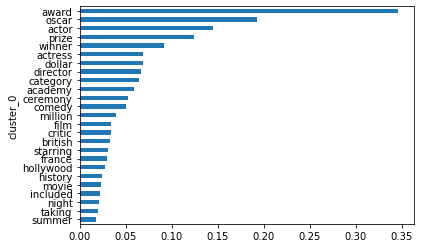

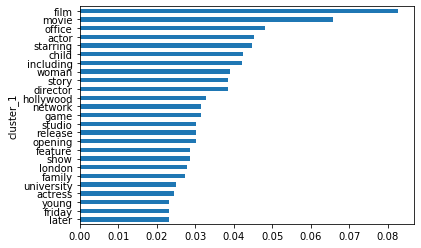

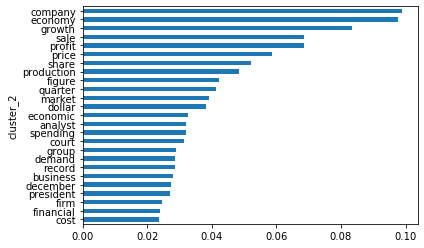

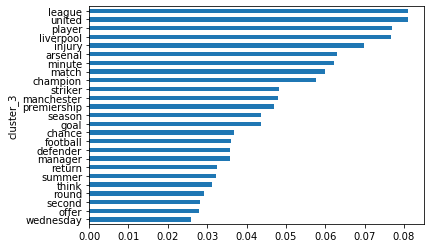

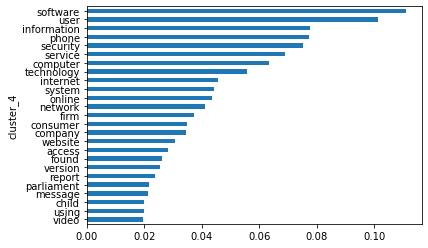

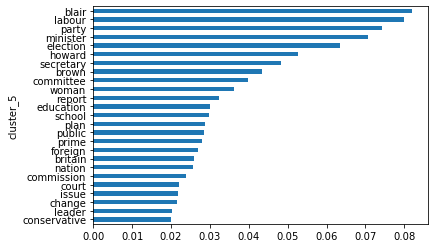

In [37]:
'''
The code below allows you to view top terms in the categories and decide if you need to change num_clusters
to make the clustering make better topics
or
to define the main theme of each topic cluster if the clustering looks good.
'''
df_doc_term_matrix = pd.DataFrame(columns=titles_short)

for i in range(len(titles_short)):
    df_top_terms_by_doc = top_feats_in_doc(tfidf_matrix,terms,i)
    df_doc_term_matrix[titles_short[i]] = df_top_terms_by_doc['feature']

df_doc_term_matrix.to_csv("doc_term_matrix.csv")

cols = []
headers = [["cluster_"+str(clusNum), str(clusNum)+"_score"] for clusNum in list(cluster_dict.keys())]

for header in headers:
    cols.extend(header)
df_cluster_term_matrix = pd.DataFrame(columns=cols)

for key, values in cluster_dict.items():
    ids = []
    for title in values:
        ids.append(titles_short.index(title))

    df_top_terms_by_cluster = top_mean_feats(tfidf_matrix, terms, grp_ids=ids)
    df_cluster_term_matrix["cluster_"+str(key)] = df_top_terms_by_cluster['feature']
    df_cluster_term_matrix[str(key)+"_score"] = df_top_terms_by_cluster['tfidf']
    
for key, values in cluster_dict.items():
    cluster = key
    df_temp = df_cluster_term_matrix.iloc[:,cluster*2:(cluster*2)+2]
    word, score = df_temp.columns.values
    df_temp = df_temp.set_index(word)
    df_temp = df_temp[score].sort_values(ascending=True)
    df_temp = df_temp[(df_temp != 0)]
    fig = plt.figure()
    ax = plt.subplot(111)
    ax = df_temp.plot(kind='barh')
    plt.show()
    fig.savefig(str(word)+".png", bbox_inches='tight', dpi=600)
    plt.close()

## <font color="red">STOP HERE AND REVIEW OUTPUT FILES</font>

#### Based on TF-IDF output define themes for each topic cluster

In [38]:
#set up cluster names using a dict
cluster_names = {0: 'football', 
                 1: 'business', 
                 2: 'entertainment',
                 3: 'politics',
                 4: 'business',
                 5: 'tech',
                 6: '6',
                 7: '7',
                 8: '8',
                 9: '9',
                10: '10',
                11: '11',
                12: '12',
                13: '13',
                14: '14',}

In [39]:
'''
Multidimensional scaling
Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. 
'''
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [40]:
'''
Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 
(a matplotlib wrapper for D3.js).

First I define some dictionaries for going from cluster number to color and to cluster name. 
I based the cluster names off the words that were closest to each cluster centroid.

For color blindness safe palette see:
http://www.draketo.de/light/english/websafe-colors-colorblind-safe
http://elpa.gnu.org/packages/rainbow-mode-0.9.el
'''
#set up colors per clusters using a dict - if more than 20 topics add colors
cluster_colors = {0: '#FF0000', 
                  1: '#800000', 
                  2: '#FFFF00', 
                  3: '#808000', 
                  4: '#00FF00', 
                  5: '#C0C0C0',
                  6: '#008000',
                  7: '#00FFFF',
                  8: '#008080',
                  9: '#0000FF',
                 10: '#000080',
                 11: '#FF00FF',
                 12: '#800080',
                 13: '#808080',
                 14: '#000000',
                 15: '#DEB887',
                 16: '#9400D3',
                 17: '#FF7F50',
                 18: '#FF69B4',
                 19: '#F0FFF0'}


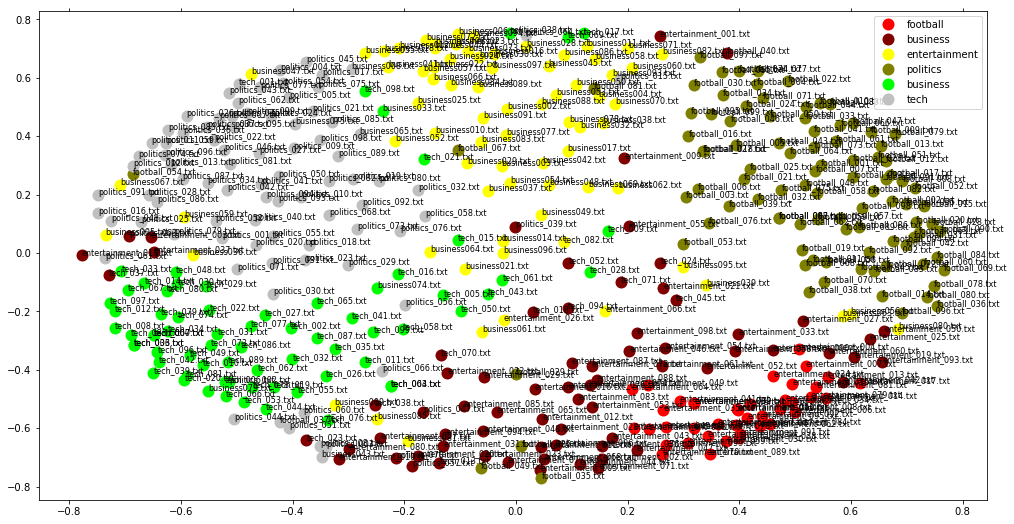

In [41]:
'''
Next, I plot the labeled observations (documents, document titles) colored by cluster using matplotlib.
'''
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles_short)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
fig.savefig('tfidf_clusters.png', dpi=600)


In [42]:
plt.close()

In [43]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles_short)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -100px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(17,8)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

# mpld3.display() #show the plot
mpld3.save_html(fig,"tfidf_clusters.html")
plt.close()

In [44]:
mpld3.save_html(fig,"tfidf_clusters.html")
#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)

For more information see: <br>
http://brandonrose.org/clustering <br>
https://buhrmann.github.io/tfidf-analysis.html <br>
https://preinventedwheel.com/easy-matplotlib-bar-chart/ <br>
https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html <br>
https://markroxor.github.io/gensim/static/notebooks/topic_coherence_tutorial.html